In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
import PIL
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential ,Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization,Dropout,Conv2D,MaxPool2D,\
Flatten , GlobalAveragePooling2D
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model


import warnings
warnings.filterwarnings("ignore")

In [ ]:
config = {
    "basic_path" : "../data-collection/FER-2013_5e/",
    "classes" : ["angry","happy","neutral","sad","surprise"],
    "batch_size" : 64,
    "epochs" : 300
}

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
train_dir = config["basic_path"]+'train'
val_dir = config["basic_path"]+'val'
test_dir = config["basic_path"]+'test'

In [8]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=config["batch_size"],
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=config["batch_size"],
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=config["batch_size"],
    class_mode='categorical',
    shuffle=False
)

Found 24176 images belonging to 5 classes.
Found 3037 images belonging to 5 classes.
Found 3006 images belonging to 5 classes.


In [26]:
# Display class indices
print("Class indices:", train_generator.class_indices)

Class indices: {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


# VGGnet Model

In [ ]:
def build_vgg_fer(input_shape=(48, 48, 1), num_classes=len(config["classes"])):
    """VGG-inspired architecture for facial emotion recognition"""
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile with SGD with Nesterov momentum
    optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    
    return model

In [37]:
# Instantiate model
model = build_vgg_fer()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 48, 48, 64)       

In [ ]:
filepath = "../training/fer_vggnet_model.h5"

checkpoint = ModelCheckpoint(filepath,monitor="val_accuracy",verbose=1,save_best_only=True,\
                            mode="max")

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.75,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    verbose=1,
    #restore_best_weights=True
    
)

In [39]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=config["epochs"], 
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        callbacks=[lr_scheduler, early_stopping]
    )

Epoch 1/300
377/377 [==============================] - 31s 79ms/step - loss: 3.8571 - accuracy: 0.2494 - val_loss: 2.5910 - val_accuracy: 0.3012 - lr: 0.0100
Epoch 2/300
377/377 [==============================] - 30s 79ms/step - loss: 4.1634 - accuracy: 0.2598 - val_loss: 3.0623 - val_accuracy: 0.3019 - lr: 0.0100
Epoch 3/300
377/377 [==============================] - 30s 79ms/step - loss: 4.2225 - accuracy: 0.2690 - val_loss: 18.4824 - val_accuracy: 0.2862 - lr: 0.0100
Epoch 4/300
377/377 [==============================] - 30s 79ms/step - loss: 4.2403 - accuracy: 0.2634 - val_loss: 8.1439 - val_accuracy: 0.2819 - lr: 0.0100
Epoch 5/300
377/377 [==============================] - 30s 79ms/step - loss: 4.0935 - accuracy: 0.2755 - val_loss: 2.4091 - val_accuracy: 0.2979 - lr: 0.0100
Epoch 6/300
377/377 [==============================] - 30s 79ms/step - loss: 4.0184 - accuracy: 0.2782 - val_loss: 10.5711 - val_accuracy: 0.2822 - lr: 0.0100
Epoch 7/300
377/377 [=============================

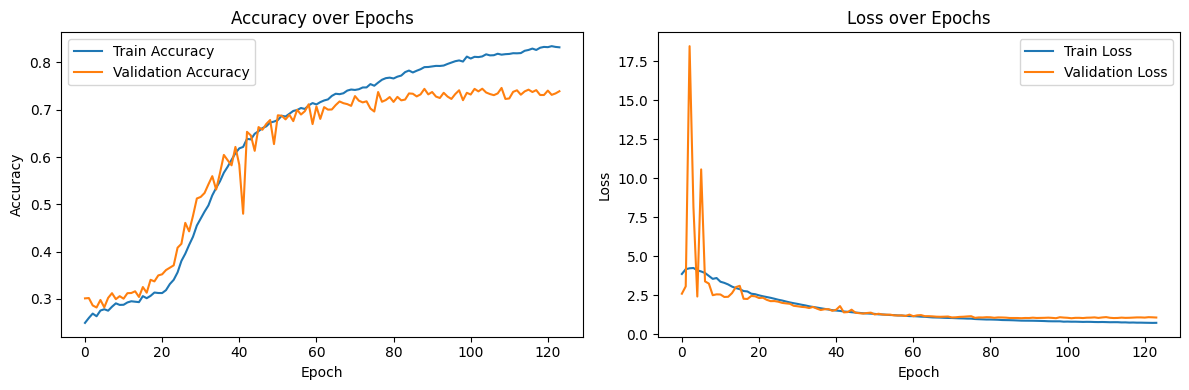

In [40]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss"""
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
model.save('../training/fer_vggnet_model.h5')

# Model evaluation

In [3]:
model = load_model('../training/fer_vggnet_model.h5')

In [11]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f} \n")

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1) 

# Get true labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

47/47 [==============================] - 3s 52ms/step - loss: 1.0206 - accuracy: 0.7558

Test Accuracy: 0.7558
Test Loss: 1.0206 

47/47 [==============================] - 1s 28ms/step


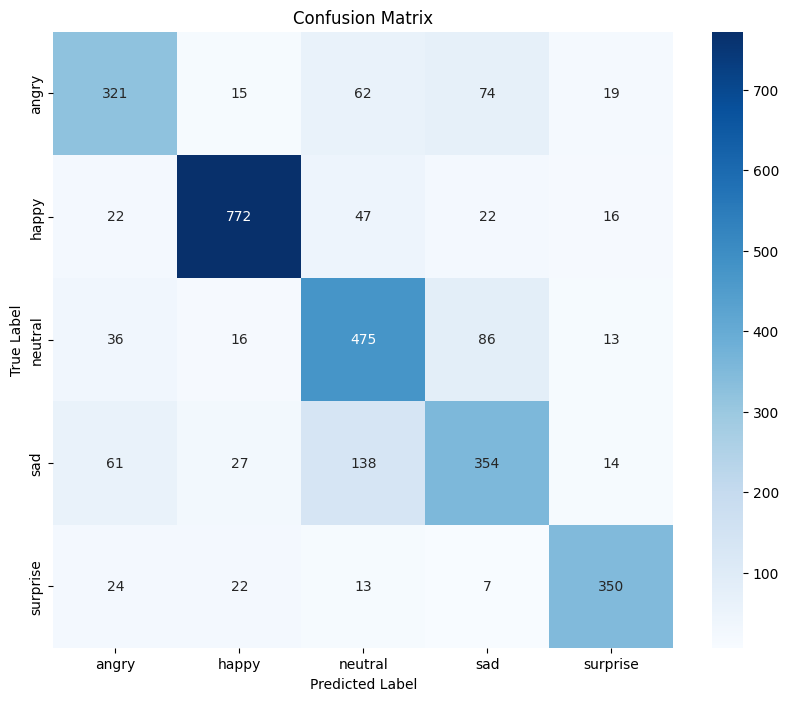

In [12]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

       angry       0.69      0.65      0.67       491
       happy       0.91      0.88      0.89       879
     neutral       0.65      0.76      0.70       626
         sad       0.65      0.60      0.62       594
    surprise       0.85      0.84      0.85       416

    accuracy                           0.76      3006
   macro avg       0.75      0.75      0.75      3006
weighted avg       0.76      0.76      0.76      3006



In [14]:
# Calculate and display per-class accuracy
class_accuracy = 100 * cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for class {class_names[i]}: {acc:.2f}%")

Accuracy for class angry: 65.38%
Accuracy for class happy: 87.83%
Accuracy for class neutral: 75.88%
Accuracy for class sad: 59.60%
Accuracy for class surprise: 84.13%
